# **Saylani Mass Training Program**
### **Cloud Data Engineering Module by Faizan Ahmed**

#### A basice Extract, Transform and Load (ETL) pipeline using web scrapping, pandas and sql

#### Import necessary Libraries

In [1]:
from io import StringIO
import requests
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3
from datetime import datetime
# from icecream import ic

#### Step 0: Maintaining a Log File
This step is done to record the logs while performing ETL and it is not neccessary in an ETL Pipeline

In [2]:
def log_progress(message):
    """This function logs the mentioned message of a given stage of the
    code execution to a log file. Function returns nothing"""

    with open('./logs/code_log.txt', 'a') as f:
        f.write(f'{datetime.now()}: {message}\n')

#### Step 1: Extract

In [3]:
def extract(url, table_attribs):
    """ This function aims to extract the required
    information from the website and save it to a data frame. The
    function returns the data frame for further processing. """

    soup = BeautifulSoup(requests.get(url).text, 'html.parser')
    table = soup.find('span', string=table_attribs).find_next('table')
    df = pd.read_html(StringIO(str(table)))[0]

    log_progress('Data extraction complete. Initiating Transformation process')

    return df

#### Step 2: Transform

In [4]:
def transform(df, csv_path):
    """ This function accesses the CSV file for exchange rate
    information, and adds three columns to the data frame, each
    containing the transformed version of Market Cap column to
    respective currencies"""

    exchange_rate = pd.read_csv(csv_path, index_col=0).to_dict()['Rate']

    df['MC_GBP_Billion'] = round(df['Total assets (2023) (US$ billion)'] * exchange_rate['GBP'], 2)
    df['MC_EUR_Billion'] = round(df['Total assets (2023) (US$ billion)'] * exchange_rate['EUR'], 2)
    df['MC_INR_Billion'] = round(df['Total assets (2023) (US$ billion)'] * exchange_rate['INR'], 2)

    print(df)

    log_progress('Data transformation complete. Initiating Loading process')

    return df

#### Step 3: Load

Loading data to a CSV

In [5]:
def load_to_csv(df, output_path):
    """ This function saves the final data frame as a CSV file in
    the provided path. Function returns nothing."""

    df.to_csv(output_path)

    log_progress('Data saved to CSV file')

Loading data to SQL

In [6]:
def load_to_db(df, sql_connection, table_name):
    """ This function saves the final data frame to a database
    table with the provided name. Function returns nothing."""

    df.to_sql(table_name, sql_connection, if_exists='replace', index=False)

    log_progress('Data loaded to Database as a table, Executing queries')

In [7]:
def run_query(query_statement, sql_connection):
    """ This function runs the query on the database table and
    prints the output on the terminal. Function returns nothing. """

    cursor = sql_connection.cursor()
    cursor.execute(query_statement)
    result = cursor.fetchall()

    log_progress('Process Complete')

    return result

#### Step 4:Performing Analytics

In [8]:
import seaborn as sns

import matplotlib.pyplot as plt

def perform_analytics(db_name, query):
    """
    Connects to the SQLite database, executes the given query, and returns the result as a DataFrame.
    Also performs basic analytics and generates plots.

    Parameters:
    db_name (str): The name of the SQLite database file.
    query (str): The SQL query to be executed.

    Returns:
    pd.DataFrame: The result of the query as a DataFrame.
    """
    log_progress('Doing Analytics')
    try:
        # Connect to the SQLite database
        conn = sqlite3.connect(db_name)
        
        # Execute the query and fetch the result
        result = pd.read_sql_query(query, conn)
        log_progress('Read the SQL query')
        # Close the connection
        conn.close()
        
        # Plotting the biggest banks by market cap
        top_banks = result.sort_values(by='Total assets (2023) (US$ billion)', ascending=False).head(20)
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Total assets (2023) (US$ billion)', y='Bank name', data=top_banks, palette='viridis')
        plt.title('Top 20 Banks by Market Cap')
        plt.show()
        
        log_progress('Process Complete returning to main')
        return result
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


### Executing Pipeline

    Rank                                Bank name  \
0      1  Industrial and Commercial Bank of China   
1      2               Agricultural Bank of China   
2      3                  China Construction Bank   
3      4                            Bank of China   
4      5                           JPMorgan Chase   
..   ...                                      ...   
95    96                            Handelsbanken   
96    97                 Industrial Bank of Korea   
97    98                                      DNB   
98    99                      Qatar National Bank   
99   100                                 VTB Bank   

    Total assets (2023) (US$ billion)  MC_GBP_Billion  MC_EUR_Billion  \
0                             6303.44         5042.75         6114.34   
1                             5623.12         4498.50         5454.43   
2                             5400.28         4320.22         5238.27   
3                             4578.28         3662.62         4440.93  

C:\Users\pc\AppData\Local\Temp\ipykernel_4036\1297490800.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total assets (2023) (US$ billion)', y='Bank name', data=top_banks, palette='viridis')


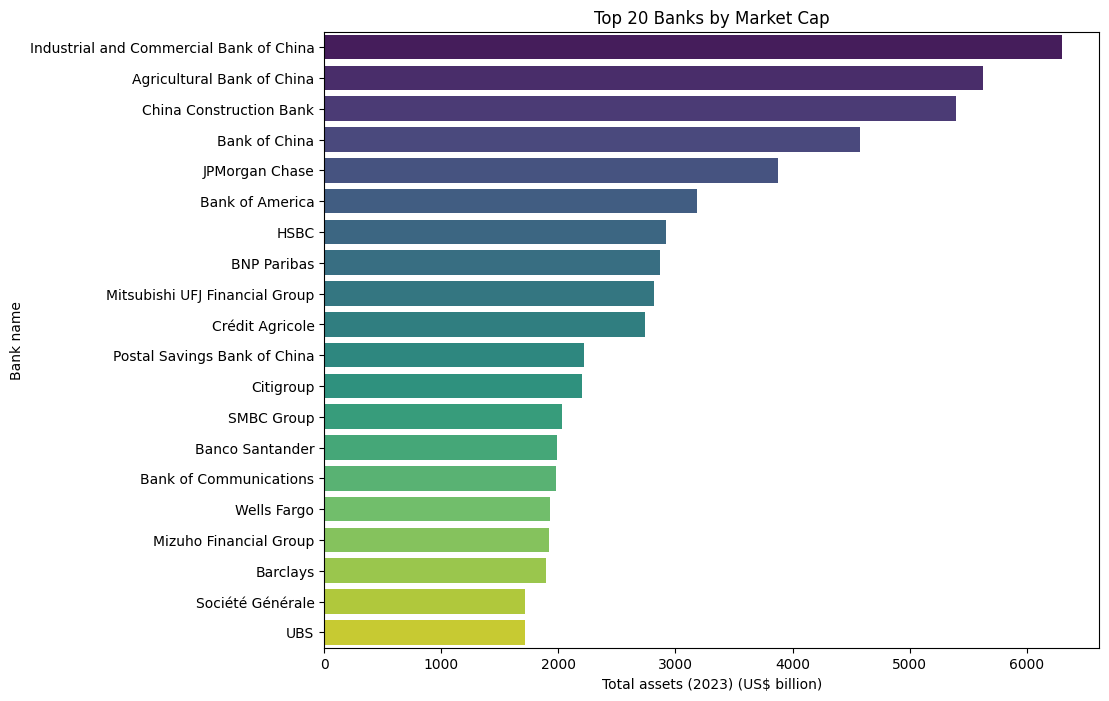

    Rank                                Bank name  \
0      1  Industrial and Commercial Bank of China   
1      2               Agricultural Bank of China   
2      3                  China Construction Bank   
3      4                            Bank of China   
4      5                           JPMorgan Chase   
5      6                          Bank of America   
6      7                                     HSBC   
7      8                              BNP Paribas   
8      9           Mitsubishi UFJ Financial Group   
9     10                          Crédit Agricole   
10    11             Postal Savings Bank of China   
11    12                                Citigroup   
12    13                               SMBC Group   
13    14                          Banco Santander   
14    15                   Bank of Communications   
15    16                              Wells Fargo   
16    17                   Mizuho Financial Group   
17    18                                 Barcl

In [9]:
if __name__ == '__main__':
    # url = 'https://web.archive.org/web/20230908091635/https://en.wikipedia.org/wiki/List_of_largest_banks'
    url = 'https://en.wikipedia.org/wiki/List_of_largest_banks'
    output_csv_path = './output/Largest_banks_data.csv'
    database_name = './output/Banks.db'
    table_name = 'Largest_banks'
    
    log_progress('Preliminaries complete. Initiating ETL process')

    df = extract(url, 'By market capitalization')

    transform(df, './input/exchange_rate.csv')

    load_to_csv(df, output_csv_path)

    with sqlite3.connect(database_name) as conn:
        load_to_db(df, conn, table_name)

        print(run_query('SELECT * FROM Largest_banks', conn))

        print(run_query('SELECT AVG(MC_GBP_Billion) FROM Largest_banks', conn))

        print(run_query('SELECT "Bank name" FROM Largest_banks LIMIT 5', conn))

    # Perform analytics
    query = 'SELECT * FROM Largest_banks WHERE MC_GBP_Billion > 100 LIMIT 20'
    analytics_result = perform_analytics(database_name, query)
    if analytics_result is not None:
        print(analytics_result)
        log_progress("Analytics performed successfully.")